In [2]:
import sys
from pathlib import Path 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import duckdb

In [3]:
# Add utils path (from notebooks/ to src/utils)
sys.path.append(str((Path().resolve().parent / "src" / "utils").resolve()))
from load_data import load_csv, save_csv

# Set data directory to project_root/data/raw
project_root = Path().resolve().parent
data_dir = project_root / "data" / "raw"

# load customers.csv and Initial Exploration
df = load_csv("customers.csv", data_dir=data_dir)
if df is not None:
    display(df.head())
    display(df.tail()) 
    display(df.describe(include='all'))
    display(df.isnull().sum())
df.info()

df['gender'].value_counts()
df['region'].value_counts()

INFO:load_data:✅ CSV loaded: C:\Users\mashel\Desktop\econ_churn\data\raw\customers.csv


,customer_id,first_order_date,region,gender,birth_year
0,CUST0001,2023-11-12,South America,Other,1993
1,CUST0002,2022-09-28,Europe,Other,1993
2,CUST0003,2022-07-23,Asia,Male,1973
3,CUST0004,2024-01-30,Europe,Male,1997
4,CUST0005,2023-02-02,South America,Male,1989


,customer_id,first_order_date,region,gender,birth_year
195,CUST0196,2024-05-21,North America,Female,1989
196,CUST0197,2023-08-25,South America,Female,1985
197,CUST0198,2024-02-07,Europe,Male,1967
198,CUST0199,2023-01-27,Europe,Other,1982
199,CUST0200,2024-02-20,South America,Male,1999


,customer_id,first_order_date,region,gender,birth_year
count,200,200,200,200,200.000000
unique,200,171,4,3,NaN
top,CUST0001,2024-05-21,South America,Female,NaN
freq,1,3,52,78,NaN
mean,NaN,NaN,NaN,NaN,1979.890000
std,NaN,NaN,NaN,NaN,11.659228
min,NaN,NaN,NaN,NaN,1960.000000
25%,NaN,NaN,NaN,NaN,1970.000000
50%,NaN,NaN,NaN,NaN,1979.000000
75%,NaN,NaN,NaN,NaN,1989.000000


customer_id         0
first_order_date    0
region              0
gender              0
birth_year          0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       200 non-null    object
 1   first_order_date  200 non-null    object
 2   region            200 non-null    object
 3   gender            200 non-null    object
 4   birth_year        200 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.9+ KB


region
South America    52
Asia             51
North America    50
Europe           47
Name: count, dtype: int64

insights
| Column             | Notes                                                         |
| ------------------ | ------------------------------------------------------------- |
| `customer_id`      | ✅ Unique for all 200 rows                                     |
| `first_order_date` | 171 unique dates → some dates repeated (OK)                   |
| `region`           | 4 unique regions — looks manageable                           |
| `gender`           | 3 unique values → likely needs standardization                |
| `birth_year`       | Ranges from 1960–2000, mean = 1980 — perfect for age features |


In [4]:
# Data cleaning
# Convert first_order_date to datetime
df['first_order_date'] = pd.to_datetime(df['first_order_date'])

# Standardize gender values
df['gender'] = df['gender'].str.strip().str.title()

# Check for missing values
print(df.isna().sum())

# Ensure uniqueness
assert df['customer_id'].is_unique

customer_id         0
first_order_date    0
region              0
gender              0
birth_year          0
dtype: int64


In [5]:
# Feature Engineering

# Age
df['age'] = 2025 - df['birth_year']

# Customer tenure
df['customer_age_days'] = (pd.Timestamp.today() - df['first_order_date']).dt.days

# Loyalty flag (1+ year)
df['is_loyal'] = df['customer_age_days'] > 365

# Age Group
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 40, 60, 100],
                         labels=['Gen Z', 'Millennials', 'Gen X', 'Boomers'])

# Group rare regions
top_regions = df['region'].value_counts().nlargest(3).index
df['region_grouped'] = df['region'].where(df['region'].isin(top_regions), 'Other')

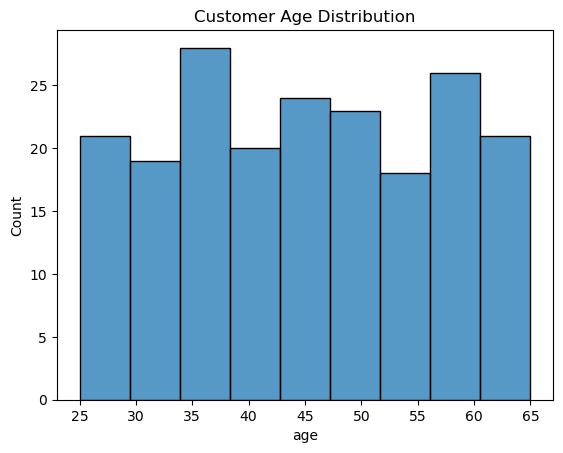

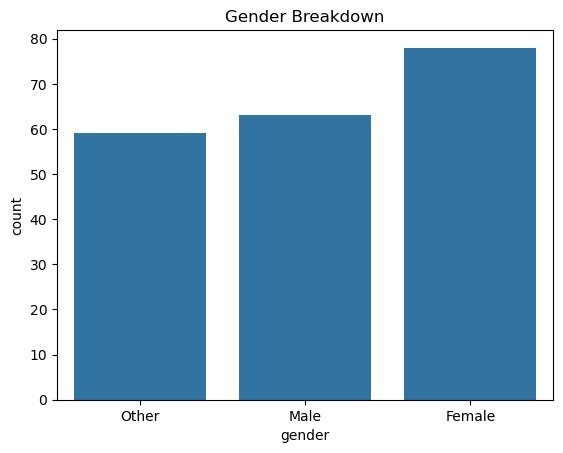

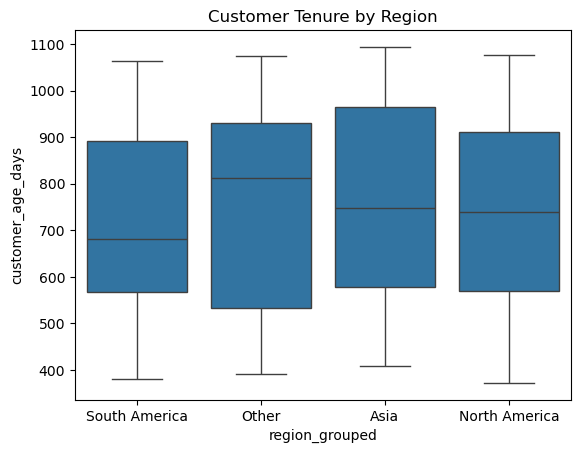

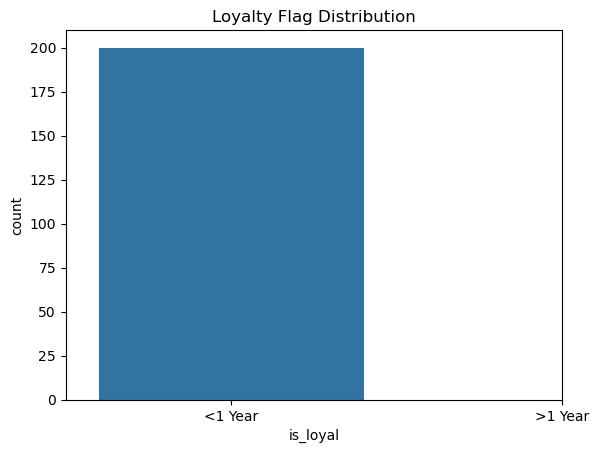

INFO:load_data:💾 Saved CSV to: C:\Users\mashel\Desktop\econ_churn\data\processed\customers_clean.csv


In [6]:
# Exploratory Data Analysis

# Age Distribution
sns.histplot(df['age'])
plt.title("Customer Age Distribution")
plt.show()

# Gender Counts
sns.countplot(x='gender', data=df)
plt.title("Gender Breakdown")
plt.show()

# Region vs Tenure
sns.boxplot(x='region_grouped', y='customer_age_days', data=df)
plt.title("Customer Tenure by Region")
plt.show()

# Loyalty Distribution
sns.countplot(x='is_loyal', data=df)
plt.title("Loyalty Flag Distribution")
plt.xticks([0,1], ['<1 Year', '>1 Year'])
plt.show()


# Save Cleaned File
save_csv(df, "customers_clean.csv")